# Instalando Spark y sus pre-requisitos

Spark y sus prerequisitos no están preinstalados en GoogleColab.
Por lo tanto, el primer paso es instalarlos. El principal pre-requisito es java y opcional 
hadoop.

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark #esta libreria encuentra spark dentro de Colab y le permite usarlo más adelante

El siguiente paso es definir las variables de entorno

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
!ls #podemos listar los archivos instalables que se descargaron

sample_data		       spark-3.1.1-bin-hadoop3.2.tgz.1
spark-3.1.1-bin-hadoop3.2      spark-3.1.1-bin-hadoop3.2.tgz.2
spark-3.1.1-bin-hadoop3.2.tgz


# Configurando la Sesión y lanzando Spark

Podemos comenzar a utilizar spark. Creamos una SparkSession.

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder\
.master("local[2]")\
.appName("Colab")\
.config('spark.driver.memory', '10g')\
.config('spark.ui.port', '4040')\
.getOrCreate()

In [ ]:
""" ejemplo dynamic allocation of executors :
spark.conf.set("spark.dynamicAllocation.enabled", "true")
spark.conf.set("spark.executor.cores", 4)
spark.conf.set("spark.dynamicAllocation.minExecutors","1")
spark.conf.set("spark.dynamicAllocation.maxExecutors","5")
"""

' ejemplo dynamic allocation of executors :\nspark.conf.set("spark.dynamicAllocation.enabled", "true")\nspark.conf.set("spark.executor.cores", 4)\nspark.conf.set("spark.dynamicAllocation.minExecutors","1")\nspark.conf.set("spark.dynamicAllocation.maxExecutors","5")\n'

In [ ]:
spark #hello I'm spark

# Modelamiento no Supervisado - Clustering k-means


## Importamos librerias



In [ ]:
# importamos librerias para pre procesamiento de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from pyspark.sql import functions as F


## Importación de archivo


Carga de datos: lo primero fue cargar el archivo .xlsx dentro de un archivo .rar y subirlo a Dropbox, de esta manera se logra trabajar de manera más automatizada sin necesidad de estar cargando el archivo cada vez que se corre el programa a través de google drive u otro sistema que requiera validación.

In [ ]:
!wget -nc -O creditos_bancarios.rar  https://www.dropbox.com/s/oycdfacyc2ydy52/creditos_bancarios.rar?dl=0
!unrar x creditos_bancarios.rar
df = pd.read_excel("creditos_bancarios.xlsx",sheet_name="SouthGermanCredit")

--2023-02-09 18:05:46--  https://www.dropbox.com/s/oycdfacyc2ydy52/creditos_bancarios.rar?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6023:18::a27d:4312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/oycdfacyc2ydy52/creditos_bancarios.rar [following]
--2023-02-09 18:05:47--  https://www.dropbox.com/s/raw/oycdfacyc2ydy52/creditos_bancarios.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6e089997fa74e05c2399f485ef.dl.dropboxusercontent.com/cd/0/inline/B2Ji5Lme_6XzsSFNfxP9c-8b7BS5gvACTszN8P1IMp_0bDuTeKkx8qczSj-BNTAPoOsldpIRiLtMDnwtUyAASRFQ4EIWzKNbPh-7ec1dWwH0yUStW2u4YJNdQ7N1k5KR7Q1riBw4sCvZkvYVxiTRK384EhxdOfHqR9HH9CbLusPQ3A/file# [following]
--2023-02-09 18:05:47--  https://uc6e089997fa74e05c2399f485ef.dl.dropboxusercontent.com/cd/0/inline/B2Ji5Lme_6XzsSFNfxP9c-8b7BS5gvACTszN8P1IMp_0

In [ ]:
print(df)

     status  duration  credit_history  purpose  amount  savings  \
0         1        18               4        2    1049        1   
1         1         9               4        0    2799        1   
2         2        12               2        9     841        2   
3         1        12               4        0    2122        1   
4         1        12               4        0    2171        1   
..      ...       ...             ...      ...     ...      ...   
995       1        24               2        3    1987        1   
996       1        24               2        0    2303        1   
997       4        21               4        0   12680        5   
998       2        12               2        3    6468        5   
999       1        30               2        2    6350        5   

     employment_duration  installment_rate  personal_status_sex  \
0                      2                 4                    2   
1                      3                 2                   

## Gráficas variables seleccionadas


Análisis exploratorio: De la base de datos “SouthGermanCredit” se identifican los tipos de variables que existen, considerando de antemano que solo se pueden elegir 5 variables:
Como se observa en la siguiente tabla sólo 3 variables son numéricas (amount, age, duration) y el resto es categórica de acuerdo a la descripción que incluye el archivo excel.
Los tipos de variables son muy relevantes para realizar el clustering usando k-means dado que para que tenga sentido hacerlo todas las variables deben ser numéricas y para los casos de variables categóricas se deben transformar a dummies.
Por lo anterior se determina utilizar las 3 variables numéricas y elegir 2 adicionales en función de la campaña objetivo en la cual se van a utilizar los clusters.
Como nos interesa enfocarnos en aquellos casos que sean de bajo riesgo se incorpora la columna categórica “credit_risk” y adicionalmente se incorpora la variable “personal_status_sex” para diferenciar futuras campañas por sexo.

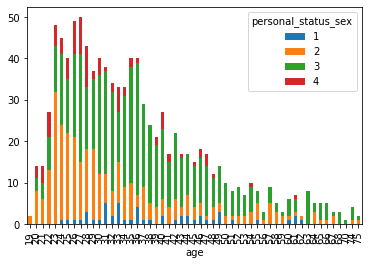

In [ ]:
#grafica age, en donde se observan edades entre 19 y 75 años y segun la categoria de personal_status_sex
df.groupby(['age', 'personal_status_sex']).size().unstack().plot.bar(stacked=True)
plt.show()

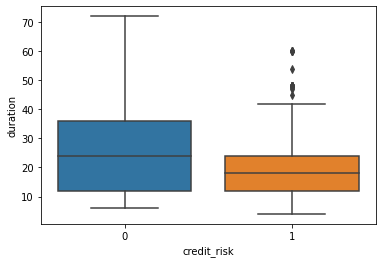

In [ ]:
#grafica duration

sn.boxplot(x='credit_risk', y='duration', data=df) 
plt.show()

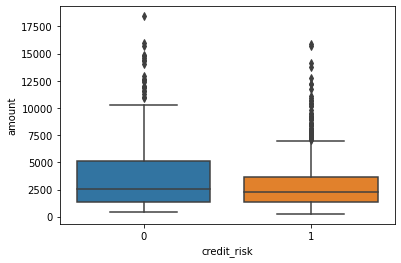

In [ ]:
#grafica amount segun clasificacion de credit_risk

sn.boxplot(x='credit_risk', y='amount', data=df) 
plt.show()

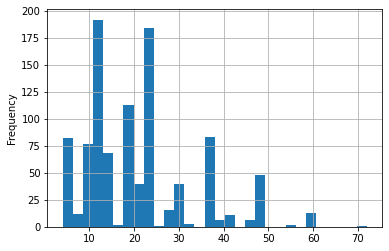

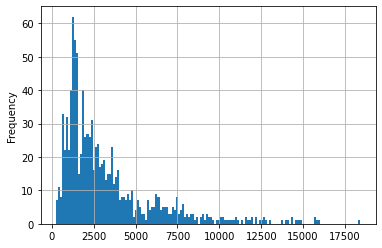

In [ ]:
df['duration'].plot(kind='hist',bins=30, grid=True )
plt.show()
df['amount'].plot(kind='hist',bins=150, grid=True )
plt.show()

## Transformación de variables asimetricas


Transformación Cox-Box: Las variables amount y duration resultaron ser asimétricas por lo tanto se procede a normalizar la data aplicando logaritmo natural..

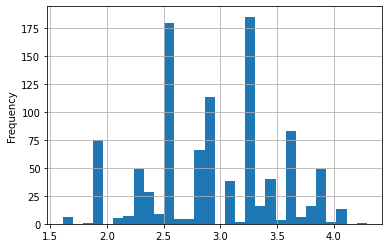

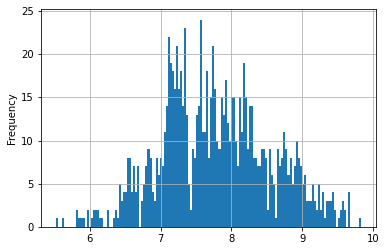

In [ ]:
df['Ln_duration'] = np.log(df['duration']+1)
df['Ln_amount'] = np.log(df['amount']+1)
df['Ln_duration'].plot(kind='hist',bins=30, grid=True )
plt.show()
df['Ln_amount'].plot(kind='hist',bins=150, grid=True )
plt.show()

## Creación Dataframe Spark

In [ ]:
sdf = spark.createDataFrame(df)
#muestra de datos top 5
sdf.show(5)
#conteo de datos null
sdf.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in sdf.columns]).show()
#estadistica descriptiva
sdf.describe().show()


+------+--------+--------------+-------+------+-------+-------------------+----------------+-------------------+-------------+-----------------+--------+---+-----------------------+-------+--------------+---+-------------+---------+--------------+-----------+------------------+------------------+
|status|duration|credit_history|purpose|amount|savings|employment_duration|installment_rate|personal_status_sex|other_debtors|present_residence|property|age|other_installment_plans|housing|number_credits|job|people_liable|telephone|foreign_worker|credit_risk|       Ln_duration|         Ln_amount|
+------+--------+--------------+-------+------+-------+-------------------+----------------+-------------------+-------------+-----------------+--------+---+-----------------------+-------+--------------+---+-------------+---------+--------------+-----------+------------------+------------------+
|     1|      18|             4|      2|  1049|      1|                  2|               4|              

Luego seleccionamos solo las columnas que formaran parte del modelo de segmentacion (5 variables)


In [ ]:
data=sdf.select("duration","amount","Ln_duration","Ln_amount","personal_status_sex","age","credit_risk")
data.printSchema()
data.dtypes

root
 |-- duration: long (nullable = true)
 |-- amount: long (nullable = true)
 |-- Ln_duration: double (nullable = true)
 |-- Ln_amount: double (nullable = true)
 |-- personal_status_sex: long (nullable = true)
 |-- age: long (nullable = true)
 |-- credit_risk: long (nullable = true)



[('duration', 'bigint'),
 ('amount', 'bigint'),
 ('Ln_duration', 'double'),
 ('Ln_amount', 'double'),
 ('personal_status_sex', 'bigint'),
 ('age', 'bigint'),
 ('credit_risk', 'bigint')]

Categóricas a Dummies: La variable “credit_risk” no fue necesaria cambiarla ya que viene en formato 1 y 0, en cambio la variable “personal_status_sex” se le da tratamiento para agrupar en solo 2 categorías (0: Hombres y 1:Mujer) .

In [ ]:
#Ajuste de variables categoricas a dummy
#Hombre quedo 0 y mujer 1
from pyspark.sql import functions as F

data = data.withColumn('sexo', F.when((data.personal_status_sex==1) | (data.personal_status_sex==3) , 0).otherwise(1))
data.select("personal_status_sex","sexo").distinct().show()

+-------------------+----+
|personal_status_sex|sexo|
+-------------------+----+
|                  3|   0|
|                  2|   1|
|                  4|   1|
|                  1|   0|
+-------------------+----+



A diferencia de otras librerias, por ej sklearn, spark requiere que todas las features que serán analizadas por ML estén dentro de una sola columna. Ocuparemos una función de feature engineering de spark para crear esa columna de tipo vector que contendrá nuestras 3 columnas

In [ ]:
data.printSchema()
data.dtypes

root
 |-- duration: long (nullable = true)
 |-- amount: long (nullable = true)
 |-- Ln_duration: double (nullable = true)
 |-- Ln_amount: double (nullable = true)
 |-- personal_status_sex: long (nullable = true)
 |-- age: long (nullable = true)
 |-- credit_risk: long (nullable = true)
 |-- sexo: integer (nullable = false)



[('duration', 'bigint'),
 ('amount', 'bigint'),
 ('Ln_duration', 'double'),
 ('Ln_amount', 'double'),
 ('personal_status_sex', 'bigint'),
 ('age', 'bigint'),
 ('credit_risk', 'bigint'),
 ('sexo', 'int')]

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler

In [ ]:
#concatena las columnas en una
required_features = ["Ln_duration","Ln_amount","sexo","age","credit_risk"]

assembler = VectorAssembler(inputCols=required_features, outputCol='features')
transformed_data = assembler.transform(data)
transformed_data.show(truncate=False)


+--------+------+------------------+------------------+-------------------+---+-----------+----+----------------------------------------------------+
|duration|amount|Ln_duration       |Ln_amount         |personal_status_sex|age|credit_risk|sexo|features                                            |
+--------+------+------------------+------------------+-------------------+---+-----------+----+----------------------------------------------------+
|18      |1049  |2.9444389791664403|6.956545443151569 |2                  |21 |1          |1   |[2.9444389791664403,6.956545443151569,1.0,21.0,1.0] |
|9       |2799  |2.302585092994046 |7.937374696163295 |3                  |36 |1          |0   |[2.302585092994046,7.937374696163295,0.0,36.0,1.0]  |
|12      |841   |2.5649493574615367|6.7357800142423265|2                  |23 |1          |1   |[2.5649493574615367,6.7357800142423265,1.0,23.0,1.0]|
|12      |2122  |2.5649493574615367|7.660585461703256 |3                  |39 |1          |0   |[2.5

Normalización: Por último las 5 variables seleccionadas son normalizadas en escala 0-1 para que todas tengan el mismo peso dentro del algoritmo esto es necesario.

In [ ]:
scaler = MinMaxScaler(inputCol="features",\
         outputCol="scaledFeatures")
scalerModel =  scaler.fit(transformed_data.select("features"))
scaledData = scalerModel.transform(transformed_data)
scaledData.show(truncate=False)

+--------+------+------------------+------------------+-------------------+---+-----------+----+----------------------------------------------------+---------------------------------------------------------------------+
|duration|amount|Ln_duration       |Ln_amount         |personal_status_sex|age|credit_risk|sexo|features                                            |scaledFeatures                                                       |
+--------+------+------------------+------------------+-------------------+---+-----------+----+----------------------------------------------------+---------------------------------------------------------------------+
|18      |1049  |2.9444389791664403|6.956545443151569 |2                  |21 |1          |1   |[2.9444389791664403,6.956545443151569,1.0,21.0,1.0] |[0.4979449260045862,0.333121255508293,1.0,0.03571428571428571,1.0]   |
|9       |2799  |2.302585092994046 |7.937374696163295 |3                  |36 |1          |0   |[2.302585092994046,7.937

Con la columna features normalizada en escala 0-1 ya creada podemos realizar el clustering:

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import MinMaxScaler


## Método Silueta

Se aplica el método de silueta, en donde, el valor de la silueta es una medida de cuán similar es un objeto a su propio cúmulo (cohesión) en comparación con otros cúmulos (separación), es decir a mayor valor de un conjunto de clusters simulados, mejor será la segmentación.

In [ ]:
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaledFeatures', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='scaledFeatures', k=i)
    
    KMeans_fit=KMeans_algo.fit(scaledData)
    
    output=KMeans_fit.transform(scaledData)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.6233721574891297
Silhouette Score: 0.6811380483419478
Silhouette Score: 0.5343781280578046
Silhouette Score: 0.7847391392636398
Silhouette Score: 0.5767868272731193
Silhouette Score: 0.6938498587060373
Silhouette Score: 0.5731939788216107
Silhouette Score: 0.5735879677197073


Text(0, 0.5, 'cost')

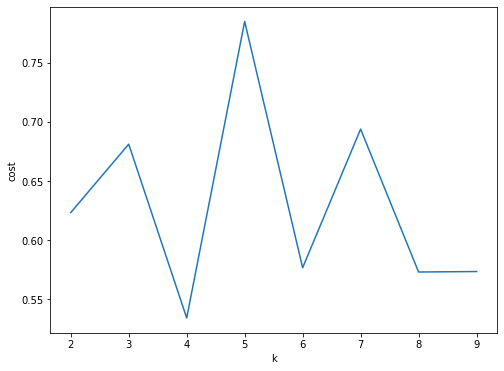

In [ ]:
#Visualizing the silhouette scores in a plot

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

Como se observa en la gráfica el mayor valor fue de 0.78 con una cantidad de 5 clusters, lo cual nos indica que es la mejor cantidad de grupos que se pueden obtener con estos datos.

## Ejecución Modelo K-Means

De acuerdo al metodo de silueta se elige el maximo local con 5 clusters.

In [ ]:
# Inicializamos el modelo y lo entrenamos
kmeans = KMeans().setK(5).setSeed(1).setFeaturesCol('scaledFeatures')
model = kmeans.fit(scaledData)

In [ ]:
# Aplicamos el modelo y obtenemos las etiquetas
predictions = model.transform(scaledData)

In [ ]:
# Visualizamos las 20 primeras etiquetas
predictions.show(20,truncate=False)

+--------+------+------------------+------------------+-------------------+---+-----------+----+----------------------------------------------------+---------------------------------------------------------------------+----------+
|duration|amount|Ln_duration       |Ln_amount         |personal_status_sex|age|credit_risk|sexo|features                                            |scaledFeatures                                                       |prediction|
+--------+------+------------------+------------------+-------------------+---+-----------+----+----------------------------------------------------+---------------------------------------------------------------------+----------+
|18      |1049  |2.9444389791664403|6.956545443151569 |2                  |21 |1          |1   |[2.9444389791664403,6.956545443151569,1.0,21.0,1.0] |[0.4979449260045862,0.333121255508293,1.0,0.03571428571428571,1.0]   |3         |
|9       |2799  |2.302585092994046 |7.937374696163295 |3                  |3

## Análisis de resultados

In [ ]:
# Calcula el tamaño de cada cluster
predictions.groupBy("prediction").count().orderBy("count").show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0|   78|
|         2|   88|
|         4|  134|
|         3|  268|
|         1|  432|
+----------+-----+



In [ ]:
# Obtiene los centroides (promedios) de cada cluster
predictions.groupBy("prediction").mean("duration","amount","sexo","age","credit_risk").orderBy("prediction").show()

+----------+------------------+------------------+---------+------------------+----------------+
|prediction|     avg(duration)|       avg(amount)|avg(sexo)|          avg(age)|avg(credit_risk)|
+----------+------------------+------------------+---------+------------------+----------------+
|         0|15.923076923076923| 2364.641025641026|      0.0| 38.23076923076923|             0.0|
|         1| 20.45601851851852|3353.8356481481483|      0.0| 37.99074074074074|             1.0|
|         2| 36.01136363636363| 6336.886363636364|      0.0| 36.21590909090909|             0.0|
|         3| 17.19402985074627| 2391.615671641791|      1.0|33.365671641791046|             1.0|
|         4|22.738805970149254| 3278.731343283582|      1.0|29.992537313432837|             0.0|
+----------+------------------+------------------+---------+------------------+----------------+



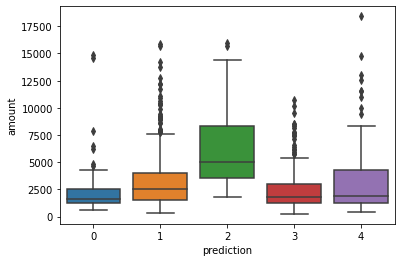

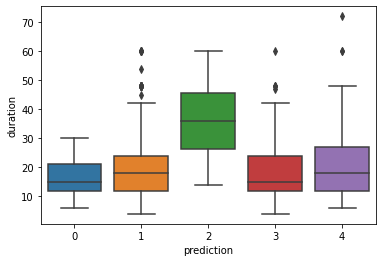

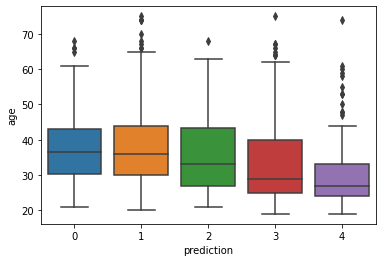

In [ ]:
final = predictions.toPandas()

sn.boxplot(x="prediction", y="amount", data=final) 
plt.show()
sn.boxplot(x="prediction", y="duration", data=final) 
plt.show()
sn.boxplot(x="prediction", y="age", data=final) 
plt.show()


Al verificar los centroides o promedios de cada segmento se observa que los grupos [0,1,2] corresponden a los Hombres, y los grupos [3, 4] a mujeres.
Por otra parte sólo hay 2 grupos sin riesgo (credit_risk=1) que son el grupo 1 y el grupo 3, que serán aquellos a los cuales se van a enfocar las acciones de negocios.

## Acciones de negocio

Las acciones de negocio irán enfocadas en 2 segmentos o grupos objetivos, que son los hombres sin riesgo y mujeres sin riesgo cada grupo tiene sus propias características que se verán a continuación:

In [ ]:
#caracteristicas estadisticas del segmento 1: Hombres sin riesgo
df_filtered = final[final['prediction'].isin([1])]
df_filtered.describe()

,duration,amount,Ln_duration,Ln_amount,personal_status_sex,age,credit_risk,sexo,prediction
count,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.0,432.0,432.0
mean,20.456019,3353.835648,2.915694,7.865795,2.861111,37.990741,1.0,0.0,1.0
std,11.928165,2605.809601,0.556785,0.708839,0.509006,10.861709,0.0,0.0,0.0
min,4.000000,338.000000,1.609438,5.826000,1.000000,20.000000,1.0,0.0,1.0
25%,12.000000,1518.500000,2.564949,7.326135,3.000000,30.000000,1.0,0.0,1.0
50%,18.000000,2572.500000,2.944439,7.853021,3.000000,36.000000,1.0,0.0,1.0
75%,24.000000,3989.250000,3.218876,8.291599,3.000000,44.000000,1.0,0.0,1.0
max,60.000000,15857.000000,4.110874,9.671429,3.000000,75.000000,1.0,0.0,1.0


El primer grupo de acción es el de Hombres sin riesgo,  en donde solo se considerarán aquellos casos que estén en el 50% más poblado de la muestra, es decir, entre el percentil 25 y 75. 
Se consideran en la edad de entre 30 y 44 años, para créditos con una duración entre 12 y 24 meses con montos entre 1518 DM y 3989 DM


In [ ]:
#caracteristicas estadisticas del segmento 3: Mujeres sin riesgo
df_filtered = final[final['prediction'].isin([3])]
df_filtered.describe()

,duration,amount,Ln_duration,Ln_amount,personal_status_sex,age,credit_risk,sexo,prediction
count,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.0,268.0,268.0
mean,17.194030,2391.615672,2.780612,7.520418,2.500000,33.365672,1.0,1.0,3.0
std,9.225415,1887.799727,0.495867,0.725514,0.867646,11.550275,0.0,0.0,0.0
min,4.000000,250.000000,1.609438,5.525453,2.000000,19.000000,1.0,1.0,3.0
25%,12.000000,1228.500000,2.564949,7.114357,2.000000,25.000000,1.0,1.0,3.0
50%,15.000000,1760.500000,2.772589,7.473916,2.000000,29.000000,1.0,1.0,3.0
75%,24.000000,3025.000000,3.218876,8.014986,2.500000,40.000000,1.0,1.0,3.0
max,60.000000,10722.000000,4.110874,9.280146,4.000000,75.000000,1.0,1.0,3.0


El segundo grupo de acción es el de Mujeres sin riesgo,  en donde solo se considerarán aquellos casos que estén en el 50% más poblado de la muestra, es decir, entre el percentil 25 y 75. 
Se consideran en la edad de entre 25 y 40 años, para créditos con una duración entre 12 y 24 meses con montos entre 1228 DM y 3025 DM.


## Fin
